In [1]:
%matplotlib inline
import matplotlib.image as mpimg
from torch import nn
from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from torchinfo import summary
import torch
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from PIL import Image
from utils import read_all_images, img_crop
from augmentation import augment_data, rot90, rot180, rot270, fliph, flipv, flipvh
%load_ext autoreload
%autoreload 2

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("Goodluck")

device = torch.device(device)

Goodluck


# Dataset loading

In [3]:
IMAGE_SRC_DIR = "training/images/"
IMAGE_GT_DIR = "training/groundtruth/"

IMAGES_SRC = np.asarray(read_all_images(IMAGE_SRC_DIR))
IMAGES_GT = np.asarray(read_all_images(IMAGE_GT_DIR))

IMAGES_SRC.shape

(100, 400, 400, 3)

# Augment data

Testing multiple examples

In [4]:
def visualize_augmented_data():
  rot90_images, rot90_gt = rot90(IMAGES_SRC, IMAGES_GT)
  rot180_images, rot180_gt = rot180(IMAGES_SRC, IMAGES_GT)
  rot270_images, rot270_gt = rot270(IMAGES_SRC, IMAGES_GT)
  fliph_images, fliph_gt = fliph(IMAGES_SRC, IMAGES_GT)
  flipv_images, flipv_gt = flipv(IMAGES_SRC, IMAGES_GT)
  flipvh_images, flipvh_gt = flipvh(IMAGES_SRC, IMAGES_GT)
  fig = plt.figure(figsize=(50, 15))
  fig.add_subplot(2, 7, 1)
  plt.imshow(IMAGES_SRC[0])
  plt.title("Original Image")
  fig.add_subplot(2, 7, 2)
  plt.imshow(rot90_images[0])
  plt.title("Rotated 90")
  fig.add_subplot(2, 7, 3)
  plt.imshow(rot180_images[0])
  plt.title("Rotated 180")
  fig.add_subplot(2, 7, 4)
  plt.imshow(rot270_images[0])
  plt.title("Rotated 270")
  fig.add_subplot(2, 7, 5)
  plt.imshow(fliph_images[0])
  plt.title("Flip Horizontal")
  fig.add_subplot(2, 7, 6)
  plt.imshow(flipv_images[0])
  plt.title("Flip Vertical")
  fig.add_subplot(2, 7, 7)
  plt.imshow(flipvh_images[0])
  plt.title("Flip Both")
  fig.add_subplot(2, 7, 8)
  plt.imshow(IMAGES_GT[0])
  plt.title("Original GT")
  fig.add_subplot(2, 7, 9)
  plt.imshow(rot90_gt[0])
  plt.title("Rotated 90")
  fig.add_subplot(2, 7, 10)
  plt.imshow(rot180_gt[0])
  plt.title("Rotated 180")
  fig.add_subplot(2, 7, 11)
  plt.imshow(rot270_gt[0])
  plt.title("Rotated 270")
  fig.add_subplot(2, 7, 12)
  plt.imshow(fliph_gt[0])
  plt.title("Flip Horizontal")
  fig.add_subplot(2, 7, 13)
  plt.imshow(flipv_gt[0])
  plt.title("Flip Vertical")
  fig.add_subplot(2, 7, 14)
  plt.imshow(flipvh_gt[0])
  plt.title("Flip Both")
  plt.show()

#visualize_augmented_data()


In [5]:
#augmented_src, augmented_gt = augment_data(IMAGES_SRC, IMAGES_GT)
augmented_src, augmented_gt = IMAGES_SRC, IMAGES_GT
print(augmented_src.shape)
print(augmented_gt.shape)

(100, 400, 400, 3)
(100, 400, 400)


## crop

In [6]:
PATCH_SIZE = 100
cropped_src, cropped_gt = np.asarray([img_crop(img, PATCH_SIZE, PATCH_SIZE) for img in augmented_src]).reshape((-1, PATCH_SIZE, PATCH_SIZE, 3)), np.asarray([img_crop(img, PATCH_SIZE, PATCH_SIZE) for img in augmented_gt]).reshape((-1, PATCH_SIZE, PATCH_SIZE))
print(cropped_src.shape)
print(cropped_gt.shape)

(1600, 100, 100, 3)
(1600, 100, 100)


# Dataset loading

In [7]:
ds_src, ds_gt = torch.stack([transforms.ToTensor()(i) for i in cropped_src]), torch.stack([transforms.ToTensor()(i) for i in cropped_gt]).squeeze()
print(ds_src.shape)
print(ds_gt.shape)

torch.Size([1600, 3, 100, 100])
torch.Size([1600, 100, 100])


In [8]:
dataset = TensorDataset(ds_src, ds_gt)

## + splitting

In [9]:
def split_dataset(dataset):
  train_size = int(len(dataset) * 0.7)
  test_size = len(dataset) - train_size
  return torch.utils.data.random_split(dataset, [train_size, test_size])

train_ds, test_ds = split_dataset(dataset)

# Model definition

In [24]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
            nn.LeakyReLU(0.1),
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.LeakyReLU(0.1),
        )

        self.unconv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, stride=2, kernel_size=4, padding=1),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(16, 3, stride=2, kernel_size=4, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.unconv(x)

        return x
    
summary(UNet(), input_size=(6, 3, 100, 100))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [6, 3, 100, 100]          --
├─Sequential: 1-1                        [6, 32, 25, 25]           --
│    └─Conv2d: 2-1                       [6, 16, 100, 100]         1,216
│    └─BatchNorm2d: 2-2                  [6, 16, 100, 100]         32
│    └─MaxPool2d: 2-3                    [6, 16, 50, 50]           --
│    └─LeakyReLU: 2-4                    [6, 16, 50, 50]           --
│    └─Conv2d: 2-5                       [6, 32, 50, 50]           12,832
│    └─BatchNorm2d: 2-6                  [6, 32, 50, 50]           64
│    └─MaxPool2d: 2-7                    [6, 32, 25, 25]           --
│    └─LeakyReLU: 2-8                    [6, 32, 25, 25]           --
├─Sequential: 1-2                        [6, 3, 100, 100]          --
│    └─ConvTranspose2d: 2-9              [6, 16, 50, 50]           8,208
│    └─LeakyReLU: 2-10                   [6, 16, 50, 50]           --
│    

In [44]:
class Model(nn.Module):
    def __init__(self, refinement_layers=3):
        super(Model, self).__init__()
        self.refinement_layers = refinement_layers
        
        self.model = UNet()
        
        self.sumup = nn.Sequential(
            nn.ConvTranspose2d(3, 1, stride=2, kernel_size=4, padding=1),
            nn.MaxPool2d(2),
            nn.Sigmoid()
        )

    def forward(self, x):
        for i in range(self.refinement_layers):
            x = self.model.forward(x)

        x = self.sumup(x)

        return x.squeeze()

model = Model(refinement_layers=1)
summary(model, input_size=(6, 3, 100, 100))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [6, 100, 100]             --
├─UNet: 1-1                              --                        --
│    └─Sequential: 2-1                   [6, 32, 25, 25]           --
│    │    └─Conv2d: 3-1                  [6, 16, 100, 100]         1,216
│    │    └─BatchNorm2d: 3-2             [6, 16, 100, 100]         32
│    │    └─MaxPool2d: 3-3               [6, 16, 50, 50]           --
│    │    └─LeakyReLU: 3-4               [6, 16, 50, 50]           --
│    │    └─Conv2d: 3-5                  [6, 32, 50, 50]           12,832
│    │    └─BatchNorm2d: 3-6             [6, 32, 50, 50]           64
│    │    └─MaxPool2d: 3-7               [6, 32, 25, 25]           --
│    │    └─LeakyReLU: 3-8               [6, 32, 25, 25]           --
│    └─Sequential: 2-2                   [6, 3, 100, 100]          --
│    │    └─ConvTranspose2d: 3-9         [6, 16, 50, 50]           8,208
│    

# Training!

In [36]:
from tqdm.notebook import tqdm
def train_epoch(model, device, train_loader, optimizer, epoch, criterion):
    model.train()

    loss_history = []
    acc_history = []
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model.forward(data)
        loss = criterion(output, target)
        output = output > 0.5
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        acc_history.append((output.eq(target).sum() / target.numel()).item())

    return acc_history, loss_history

In [37]:
def train(device, batch_size=32, epochs=60):
    pytorchDl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.functional.binary_cross_entropy

    for i in tqdm(range(epochs)):
        acc_history, loss_history = train_epoch(model, device, pytorchDl, optimizer, i, criterion)
        print("Epoch: ", i, " Accuracy: ", sum(acc_history)/len(acc_history), " Loss: ", sum(loss_history)/len(loss_history))

    return model

# Let's play!

In [35]:
model = train(device, 20, 1)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch:  0  Accuracy:  0.7765733961548124  Loss:  0.5829545472349439


# Visualize results?

torch.Size([1, 3, 100, 100])


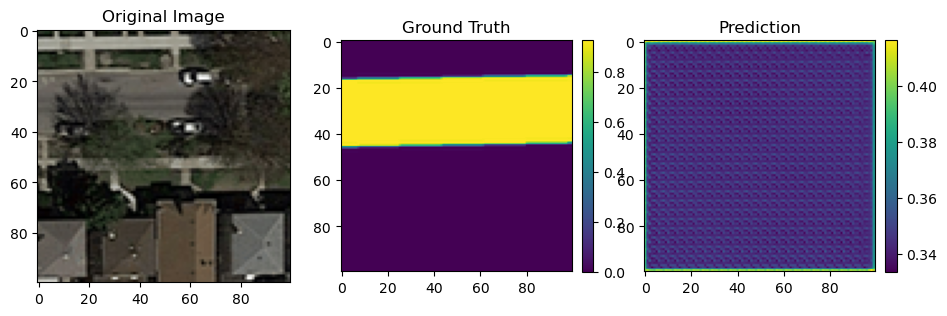

torch.Size([1, 3, 100, 100])


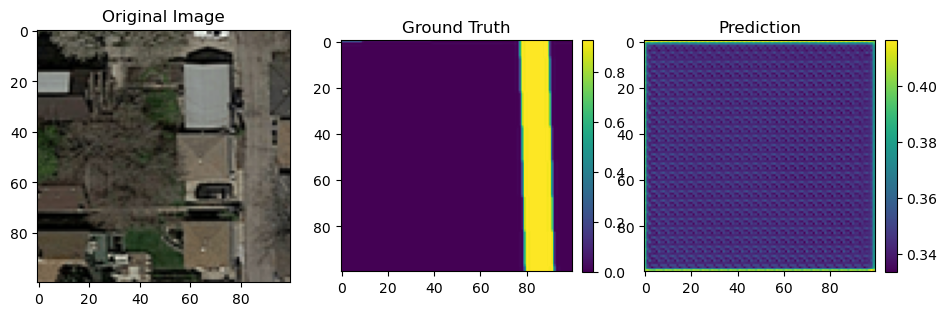

In [42]:
def visualize_result(device, model, dataset):
  model.eval()
  pytorchDl = DataLoader(dataset, batch_size=1, shuffle=True)
  for data, target in pytorchDl:
    data = data.squeeze()
    target = target.squeeze()
    inputs = data.to(device).unsqueeze(0)
    print(inputs.size())
    output = model.forward(inputs)
    data, target = data.cpu().numpy().transpose((1, 2, 0)), target.cpu().numpy()

    fig = plt.figure(figsize=(15, 15))
    fig.add_subplot(1, 4, 1)
    im = plt.imshow(data)
    plt.title("Original Image")
    fig.add_subplot(1, 4, 2)
    im = plt.imshow(target)
    fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.title("Ground Truth")
    fig.add_subplot(1, 4, 3)
    im = plt.imshow(output.cpu().detach().numpy())
    fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.title("Prediction")
    plt.show()
    break

visualize_result(device, model, train_ds)
visualize_result(device, model, test_ds)

# Making a submission